# Exploratory Data Analysis & Preprocessing

## Table of Contents

(1) Data Loading and Initial Exploration

(2) Data Understanding and Type Corrections

(3) Missing Value Analysis and Imputation

(4) Feature Engineering

(5) Exploratory Data Analysis

(6) Target Variable Analysis

(7) Feature-Target Relationships

(8) Data Export for Modeling

<hr>

(1) Data Loading and Initial Exploration

In [1]:
# Import required libraries
import json
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import skew

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [2]:
# Load the datasets
train_df = pd.read_csv("download/train.csv")
test_df = pd.read_csv("download/test.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Total features: {train_df.shape[1] - 1}")  # Excluding target variable

# Combine datasets for consistent preprocessing
# This prevents data leakage as we're only doing type conversions and domain-based imputations
df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print(f"Combined dataset shape: {df_all.shape}")

Training data shape: (1460, 81)
Test data shape: (1459, 80)
Total features: 80
Combined dataset shape: (2919, 81)


In [3]:
# Quick overview of the data
df_all.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [4]:
# Check data types and missing values
print("Data Types Overview:")
print(df_all.dtypes.value_counts())
print(f"\nUnique data types: {df_all.dtypes.unique()}")

# Missing values summary
missing_summary = df_all.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(f"Features with missing values: {len(missing_summary)}")
print("\nTop features with missing values:")
print(missing_summary.head(10))

Data Types Overview:
object     43
int64      26
float64    12
Name: count, dtype: int64

Unique data types: [dtype('int64') dtype('O') dtype('float64')]
Features with missing values: 35

Top features with missing values:
PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
MasVnrType     1766
SalePrice      1459
FireplaceQu    1420
LotFrontage     486
GarageQual      159
GarageYrBlt     159
dtype: int64


<hr>

(2) Data Understanding and Type Corrections

Based on the data description, some features that appear numerical are actually categorical identifiers.

In [5]:
# Convert features that should be categorical
categorical_features = ["Id", "MSSubClass", "MoSold"]
df_all[categorical_features] = df_all[categorical_features].astype("object")

print("Converted to categorical:")
for col in categorical_features:
    print(f"- {col}: {df_all[col].dtype}")

Converted to categorical:
- Id: object
- MSSubClass: object
- MoSold: object


<hr>

(3) Missing Value Analysis and Imputation

(3.1) Domain-Based Missing Value Imputation

Many missing values in this dataset represent the absence of a feature (e.g., no pool, no garage). Based on the data description, we can impute these with "NA" to indicate absence.

In [6]:
# Features where missing values mean "Not Applicable" or "None"
na_impute_features = [
    "Alley",  # No alley access
    "BsmtCond",  # No basement
    "BsmtExposure",  # No basement
    "BsmtFinType1",  # No basement
    "BsmtFinType2",  # No basement
    "FireplaceQu",  # No fireplace
    "GarageType",  # No garage
    "GarageFinish",  # No garage
    "GarageQual",  # No garage
    "GarageCond",  # No garage
    "PoolQC",  # No pool
    "Fence",  # No fence
    "MiscFeature",  # No miscellaneous feature
]

print(f"Imputing {len(na_impute_features)} features with 'NA' for missing values")

# Impute with "NA"
na_imputer = SimpleImputer(strategy="constant", fill_value="NA")
df_all[na_impute_features] = na_imputer.fit_transform(df_all[na_impute_features])

Imputing 13 features with 'NA' for missing values


(3.2) Ordinal Feature Encoding

Many features are ordinal with a clear quality/condition ranking. We'll convert these to numerical scales.

In [7]:
# Define ordinal mappings based on data description
ordinal_mappings = {
    "LotShape": {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4},
    "LandSlope": {"Sev": 1, "Mod": 2, "Gtl": 3},
    "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
    "BsmtFinType1": {
        "NA": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6,
    },
    "BsmtFinType2": {
        "NA": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6,
    },
    "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "Functional": {
        "Sal": 1,
        "Sev": 2,
        "Maj2": 3,
        "Maj1": 4,
        "Mod": 5,
        "Min2": 6,
        "Min1": 7,
        "Typ": 8,
    },
    "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
    "GarageQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "GarageCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
    "PavedDrive": {"N": 1, "P": 2, "Y": 3},
    "PoolQC": {"NA": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
    "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
}

# Apply ordinal mappings
for feature, mapping in ordinal_mappings.items():
    df_all[feature] = df_all[feature].map(mapping)
    print(f"Encoded {feature}: {df_all[feature].unique()}")

Encoded LotShape: [4 3 2 1]
Encoded LandSlope: [3 2 1]
Encoded ExterQual: [4 3 5 2]
Encoded ExterCond: [3 4 2 1 5]
Encoded BsmtQual: [ 4.  3.  5. nan  2.]
Encoded BsmtCond: [3 4 0 2 1]
Encoded BsmtExposure: [1 4 2 3 0]
Encoded BsmtFinType1: [6 5 1 3 4 0 2]
Encoded BsmtFinType2: [1 4 0 5 3 2 6]
Encoded HeatingQC: [5 4 3 2 1]
Encoded KitchenQual: [ 4.  3.  5.  2. nan]
Encoded Functional: [ 8.  7.  4.  6.  5.  3.  2. nan]
Encoded FireplaceQu: [0 3 4 2 5 1]
Encoded GarageFinish: [2 1 3 0]
Encoded GarageQual: [3 2 4 0 5 1]
Encoded GarageCond: [3 2 0 4 1 5]
Encoded PavedDrive: [3 1 2]
Encoded PoolQC: [0 4 1 3]
Encoded Fence: [0 3 2 4 1]


(3.3) Logical Feature Corrections

Some features have logical relationships that we can enforce based on other feature values.

In [8]:
# Houses with 1 story should have 0 second floor area
df_all.loc[df_all["HouseStyle"] == "1Story", "2ndFlrSF"] = 0

# Houses without basements should have 0 basement-related areas and bathrooms
basement_features = [
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "BsmtFullBath",
    "BsmtHalfBath",
]
df_all.loc[df_all["BsmtQual"] == 0, basement_features] = 0

# Houses without garages should have 0 garage cars and area
df_all.loc[df_all["GarageType"] == "NA", ["GarageCars", "GarageArea"]] = 0

# Houses without pools should have 0 pool area
df_all.loc[df_all["PoolQC"] == 0, "PoolArea"] = 0

print("Applied logical feature corrections")

Applied logical feature corrections


(3.4) Handle Remaining Missing Values

In [9]:
# Check remaining missing values after our domain-based imputations
remaining_missing = df_all.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0].sort_values(
    ascending=False
)

if len(remaining_missing) > 0:
    print("Remaining missing values:")
    print(remaining_missing)

    # Separate numerical and categorical features for different imputation strategies
    numeric_features = df_all.select_dtypes(include=[np.number]).columns
    categorical_features = df_all.select_dtypes(include=["object"]).columns

    # Impute remaining categorical missing values with "Unknown"
    categorical_missing = remaining_missing.index.intersection(categorical_features)
    if len(categorical_missing) > 0:
        unknown_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
        df_all[categorical_missing] = unknown_imputer.fit_transform(
            df_all[categorical_missing]
        )
        print(f"Imputed {len(categorical_missing)} categorical features with 'Unknown'")
else:
    print("No remaining missing values!")

Remaining missing values:
MasVnrType      1766
SalePrice       1459
LotFrontage      486
GarageYrBlt      159
BsmtQual          81
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
Exterior1st        1
Exterior2nd        1
BsmtFinSF1         1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
KitchenQual        1
GarageCars         1
GarageArea         1
SaleType           1
dtype: int64
Imputed 7 categorical features with 'Unknown'


<hr>

(4) Feature Engineering

In [10]:
# Create some additional features that might be useful
df_all["TotalSF"] = df_all["TotalBsmtSF"] + df_all["1stFlrSF"] + df_all["2ndFlrSF"]
df_all["TotalBathrooms"] = (
    df_all["FullBath"]
    + (0.5 * df_all["HalfBath"])
    + df_all["BsmtFullBath"]
    + (0.5 * df_all["BsmtHalfBath"])
)
df_all["HouseAge"] = df_all["YrSold"] - df_all["YearBuilt"]
df_all["RemodAge"] = df_all["YrSold"] - df_all["YearRemodAdd"]

print("Created additional features:")
print("- TotalSF: Total square footage")
print("- TotalBathrooms: Total bathroom count")
print("- HouseAge: Age of house at time of sale")
print("- RemodAge: Years since last remodel at time of sale")

Created additional features:
- TotalSF: Total square footage
- TotalBathrooms: Total bathroom count
- HouseAge: Age of house at time of sale
- RemodAge: Years since last remodel at time of sale


<hr>

(5) Exploratory Data Analysis

(5.1) Dataset Overview

In [11]:
print("Final Dataset Summary:")
print(f"Shape: {df_all.shape}")
print(f"Numerical features: {len(df_all.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df_all.select_dtypes(include=['object']).columns)}")
print(f"Missing values: {df_all.isnull().sum().sum()}")

Final Dataset Summary:
Shape: (2919, 85)
Numerical features: 58
Categorical features: 27
Missing values: 2224


(5.2) Numerical Features Distribution

Analyzing 57 numerical features


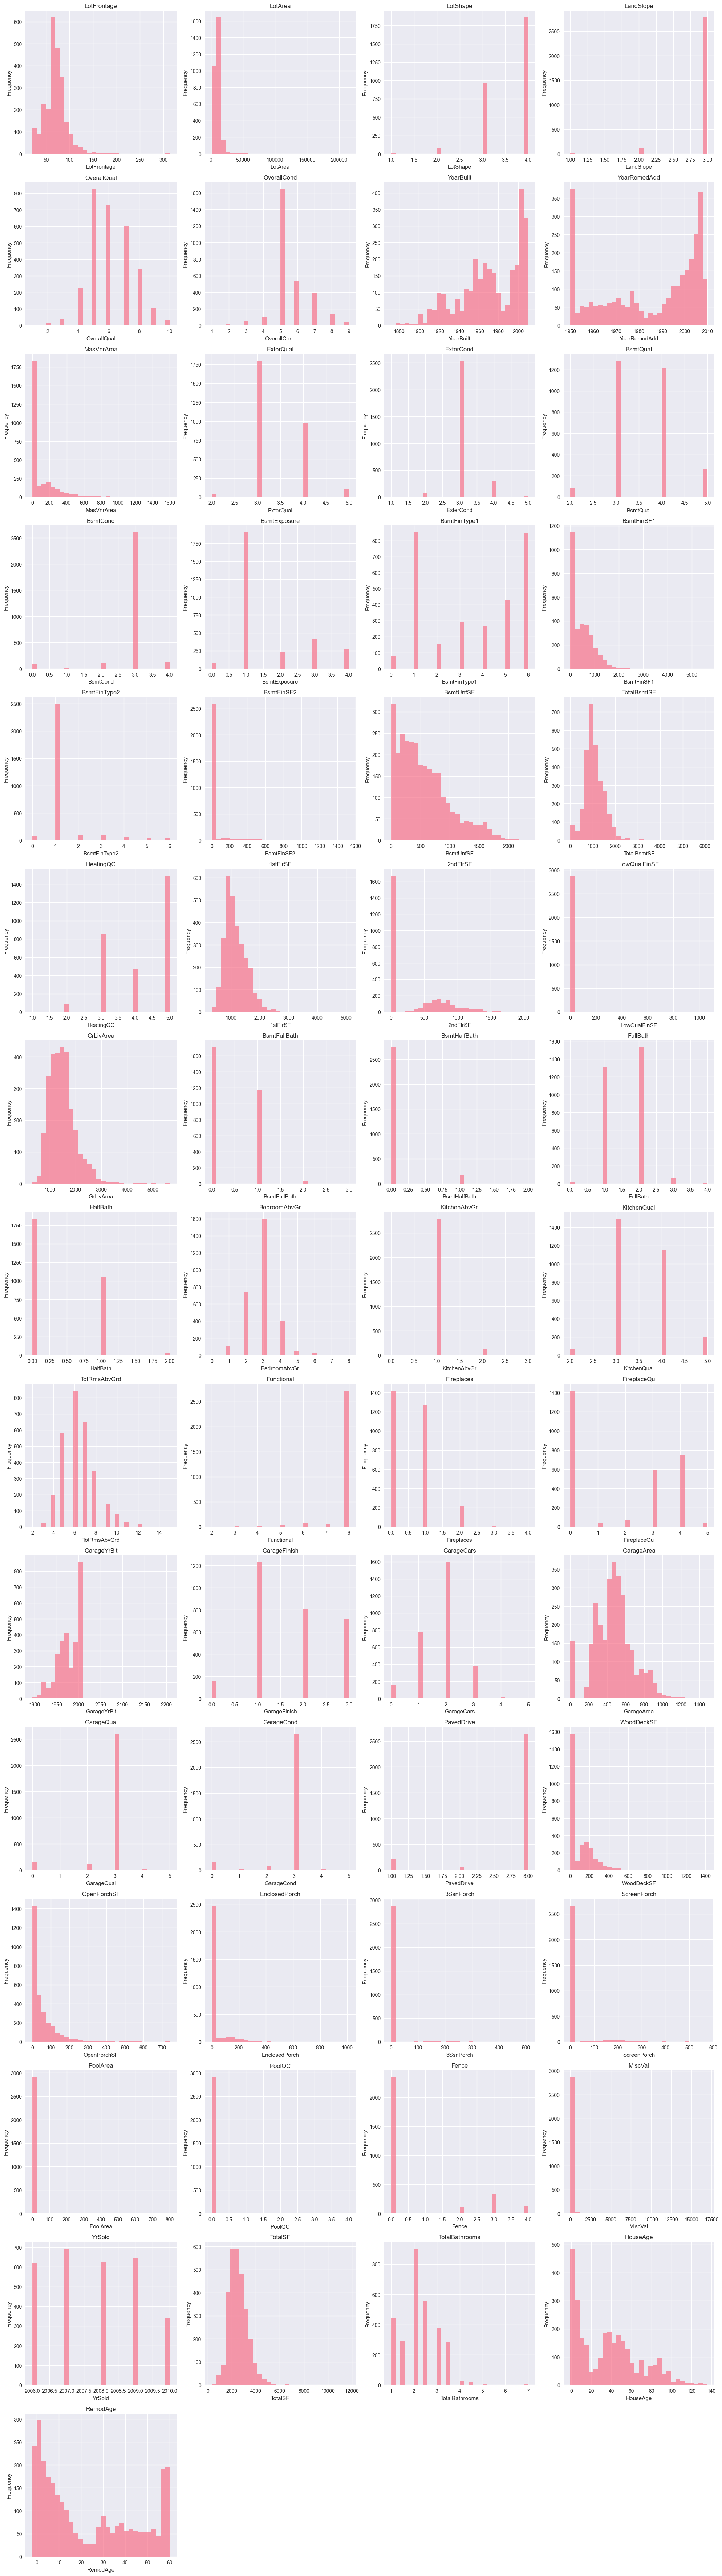

In [12]:
# Analyze numerical features
numerical_features = df_all.select_dtypes(include=[np.number]).columns
numerical_features = numerical_features.drop("SalePrice")  # Remove target if present

print(f"Analyzing {len(numerical_features)} numerical features")

# Create histograms for numerical features
fig, axes = plt.subplots(
    nrows=len(numerical_features) // 4 + 1,
    ncols=4,
    figsize=(20, 5 * len(numerical_features) // 4),
)
axes = axes.ravel()

for idx, feature in enumerate(numerical_features):
    if idx < len(axes):
        df_all[feature].hist(bins=30, ax=axes[idx], alpha=0.7)
        axes[idx].set_title(f"{feature}", fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel("Frequency")

# Hide empty subplots
for idx in range(len(numerical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

(5.3) Categorical Features Distribution

Analyzing 26 categorical features


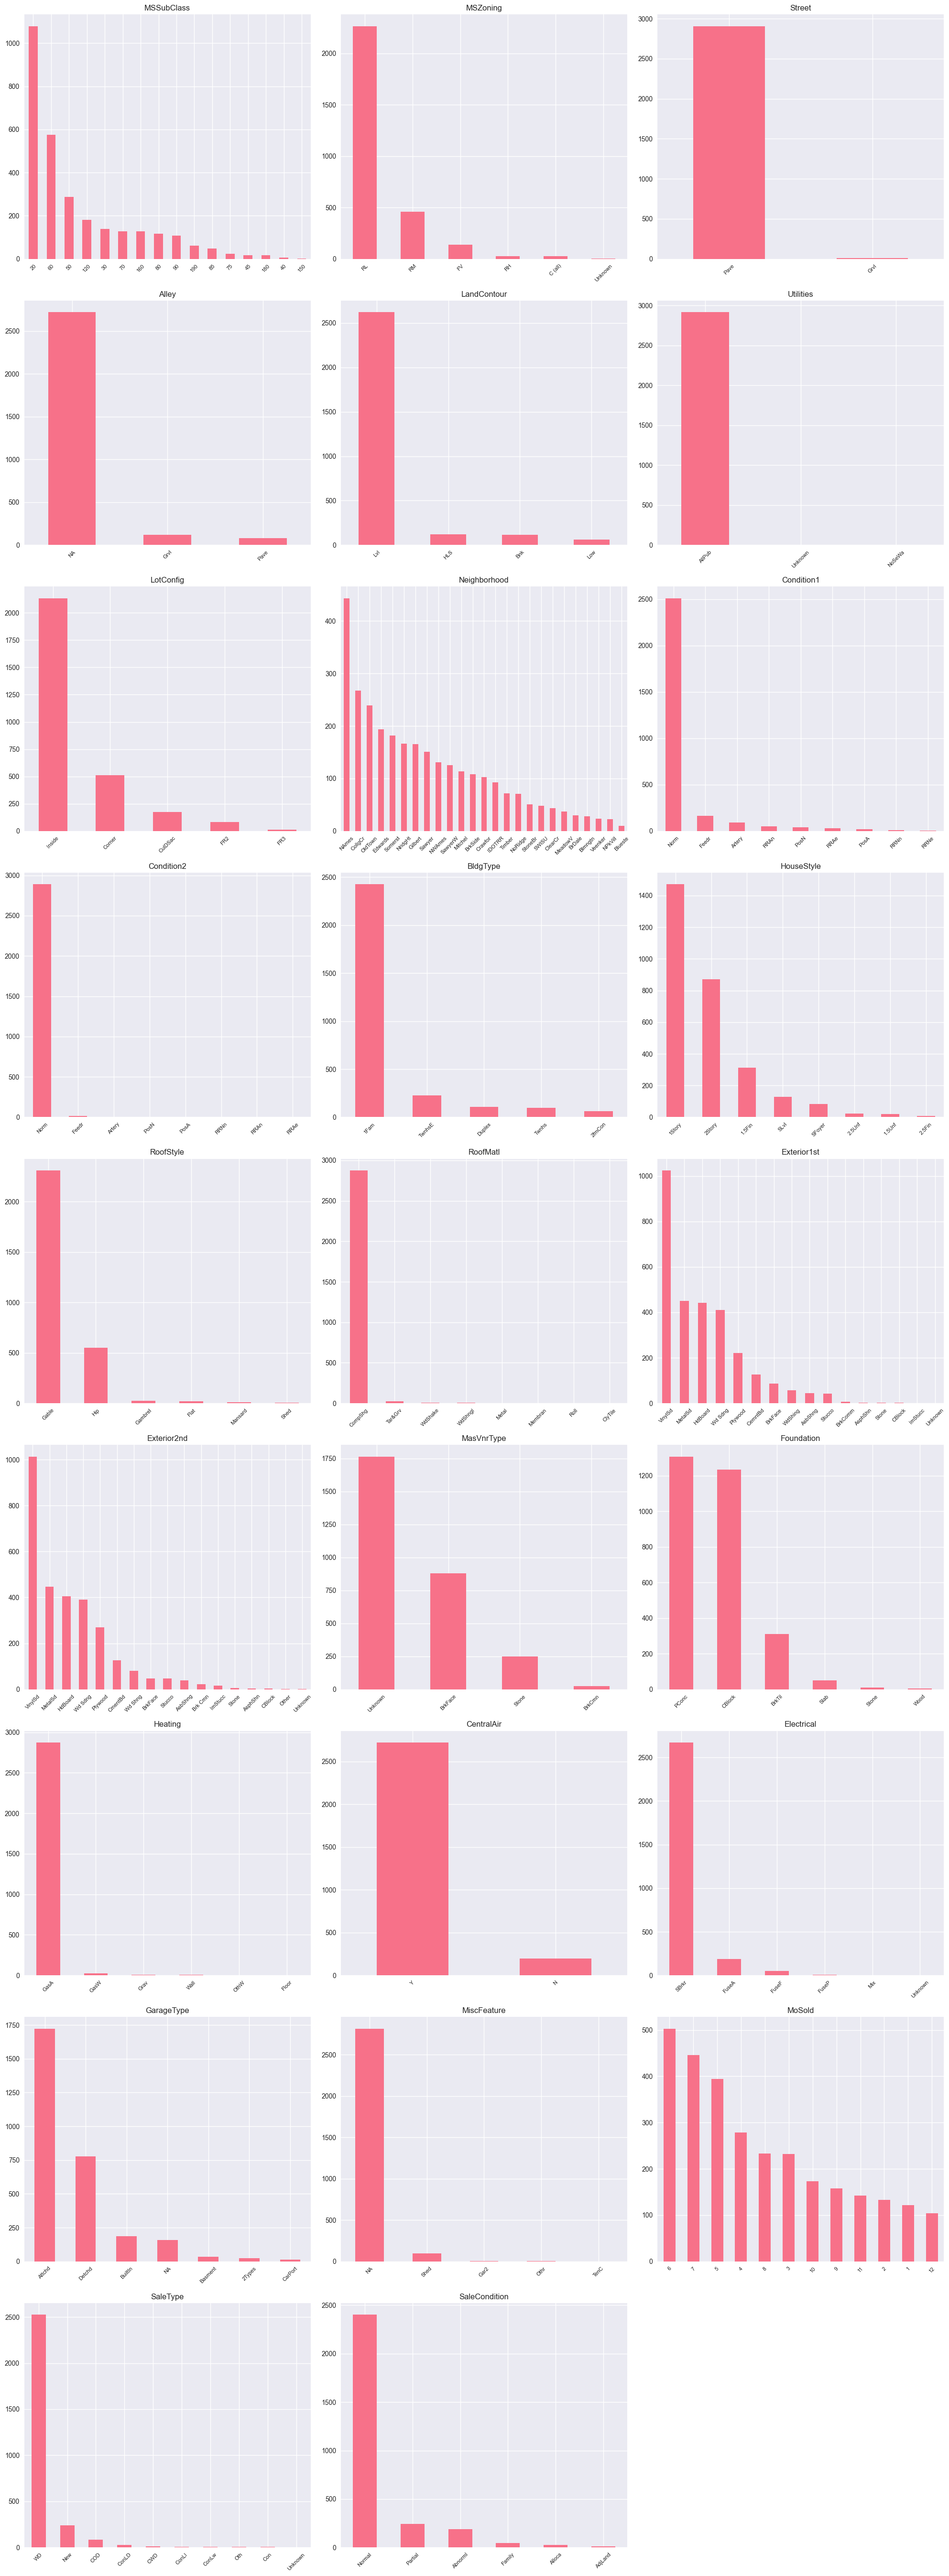

In [13]:
# Analyze categorical features
categorical_features = df_all.select_dtypes(include=["object"]).columns
categorical_features = categorical_features.drop("Id")  # Remove ID

print(f"Analyzing {len(categorical_features)} categorical features")

# Create bar plots for categorical features
n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows))
axes = axes.ravel() if n_rows > 1 else [axes] if n_rows == 1 else axes

for idx, feature in enumerate(categorical_features):
    if idx < len(axes):
        value_counts = df_all[feature].value_counts()
        value_counts.plot(kind="bar", ax=axes[idx], rot=45)
        axes[idx].set_title(f"{feature}", fontsize=12)
        axes[idx].set_xlabel("")
        axes[idx].tick_params(axis="x", labelsize=8)

# Hide empty subplots
for idx in range(len(categorical_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

<hr>

(6) Target Variable Analysis

Training data shape: (1460, 85)


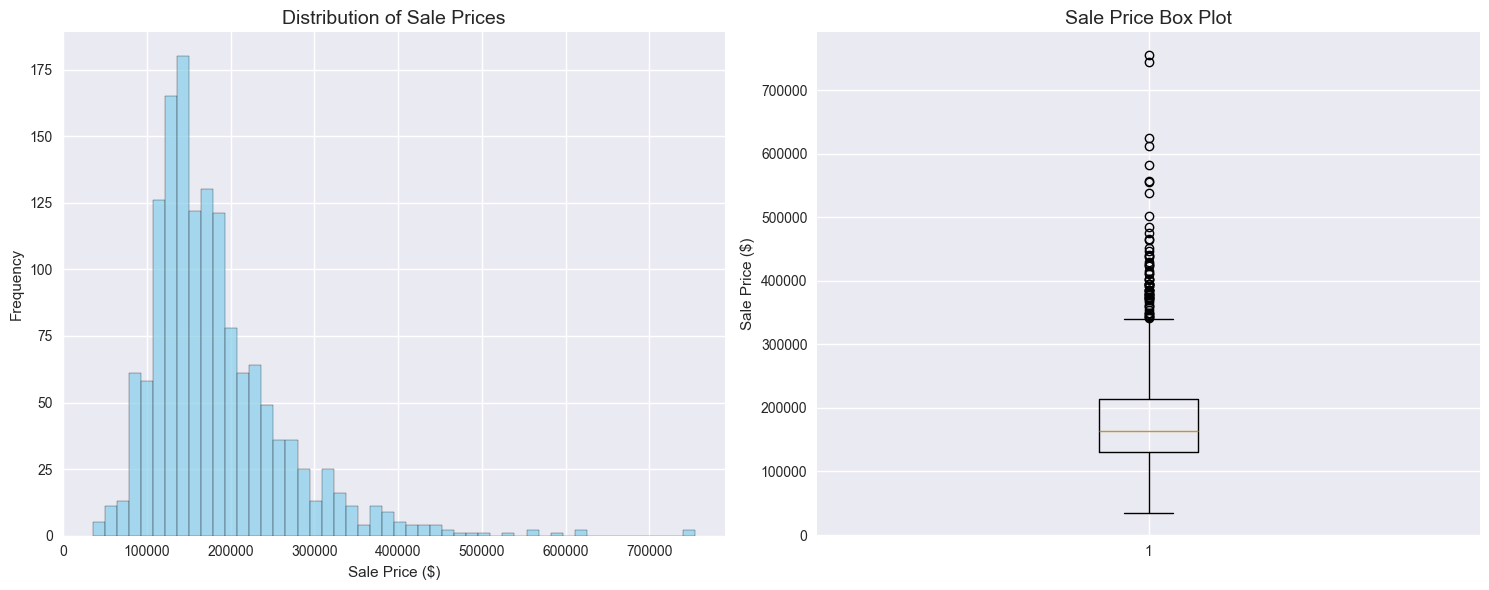

SalePrice Summary Statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [14]:
# Recover training data for target analysis
train_data = df_all.head(len(train_df))
print(f"Training data shape: {train_data.shape}")

# Analyze SalePrice distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
axes[0].hist(
    train_data["SalePrice"], bins=50, alpha=0.7, color="skyblue", edgecolor="black"
)
axes[0].set_title("Distribution of Sale Prices", fontsize=14)
axes[0].set_xlabel("Sale Price ($)")
axes[0].set_ylabel("Frequency")

# Box plot
axes[1].boxplot(train_data["SalePrice"])
axes[1].set_title("Sale Price Box Plot", fontsize=14)
axes[1].set_ylabel("Sale Price ($)")

plt.tight_layout()
plt.show()

# Summary statistics
print("SalePrice Summary Statistics:")
print(train_data["SalePrice"].describe())

In [15]:
price_skewness = skew(train_data["SalePrice"])
print(f"SalePrice Skewness: {price_skewness:.3f}")

if abs(price_skewness) > 0.5:
    print(
        "SalePrice is significantly skewed. Consider log transformation for modeling."
    )

SalePrice Skewness: 1.881
SalePrice is significantly skewed. Consider log transformation for modeling.


<hr>

(7) Feature-Target Relationships

(7.1) Correlation Analysis

In [16]:
# Calculate correlations with SalePrice for numerical features
numerical_features_with_target = train_data.select_dtypes(include=[np.number]).columns
correlations = (
    train_data[numerical_features_with_target]
    .corr()["SalePrice"]
    .sort_values(ascending=False)
)

print("Top 15 features most correlated with SalePrice:")
print(correlations.head(15))
print("\nBottom 10 features least correlated with SalePrice:")
print(correlations.tail(10))

Top 15 features most correlated with SalePrice:
SalePrice         1.000000
OverallQual       0.790982
TotalSF           0.782259
GrLivArea         0.708624
ExterQual         0.682639
KitchenQual       0.659600
BsmtQual          0.644019
GarageCars        0.640409
TotalBathrooms    0.631731
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
FullBath          0.560664
GarageFinish      0.549247
TotRmsAbvGrd      0.533723
Name: SalePrice, dtype: float64

Bottom 10 features least correlated with SalePrice:
LowQualFinSF    -0.025606
YrSold          -0.028923
LandSlope       -0.051152
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Fence           -0.146942
LotShape        -0.267759
RemodAge        -0.509079
HouseAge        -0.523350
Name: SalePrice, dtype: float64


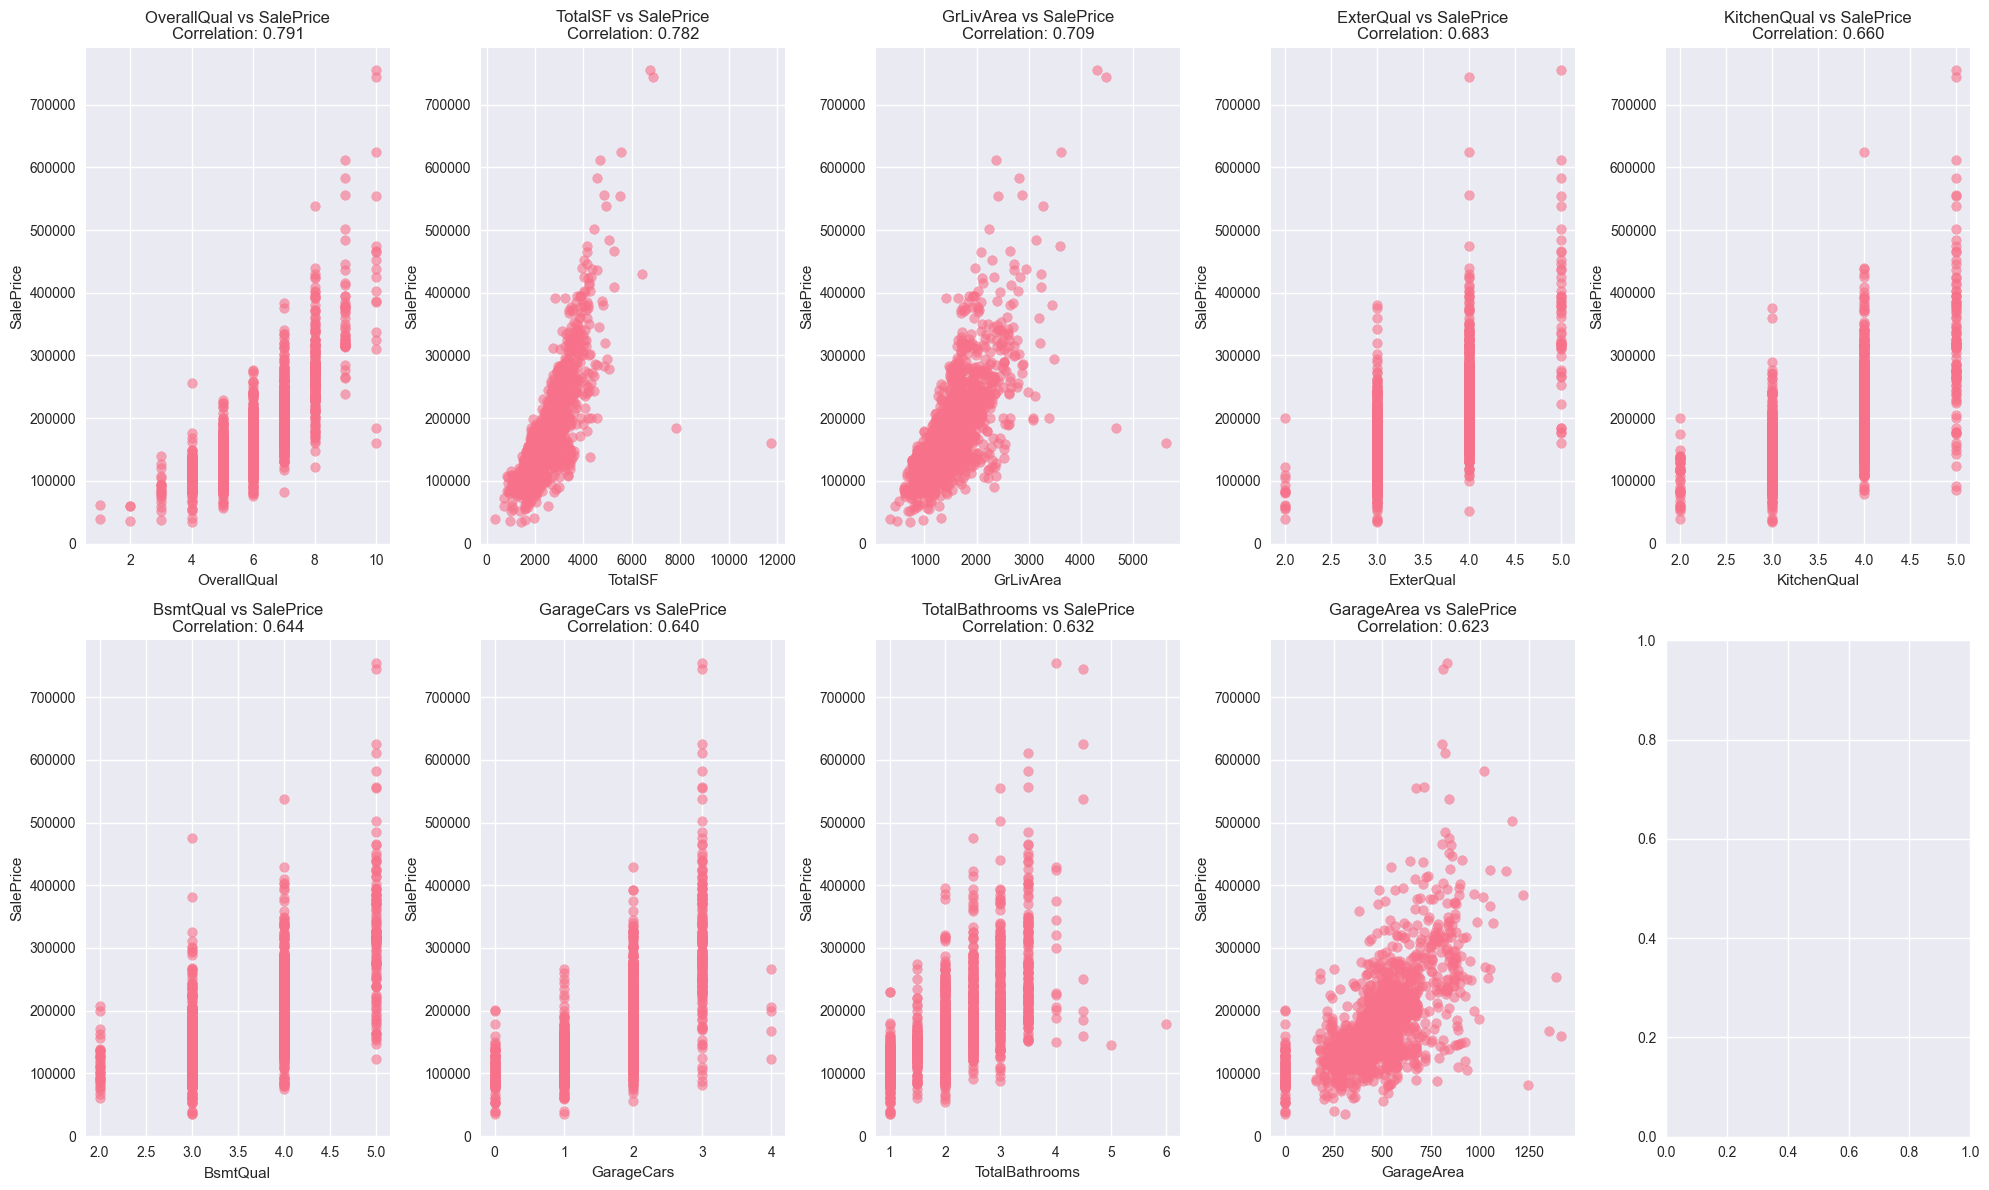

In [17]:
# Visualize top correlations
top_features = correlations.head(10).index[1:]  # Exclude SalePrice itself

fig, axes = plt.subplots(2, 5, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    axes[idx].scatter(train_data[feature], train_data["SalePrice"], alpha=0.6)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("SalePrice")
    axes[idx].set_title(
        f"{feature} vs SalePrice\nCorrelation: {correlations[feature]:.3f}"
    )

plt.tight_layout()
plt.show()

(7.2) Categorical Feature Analysis

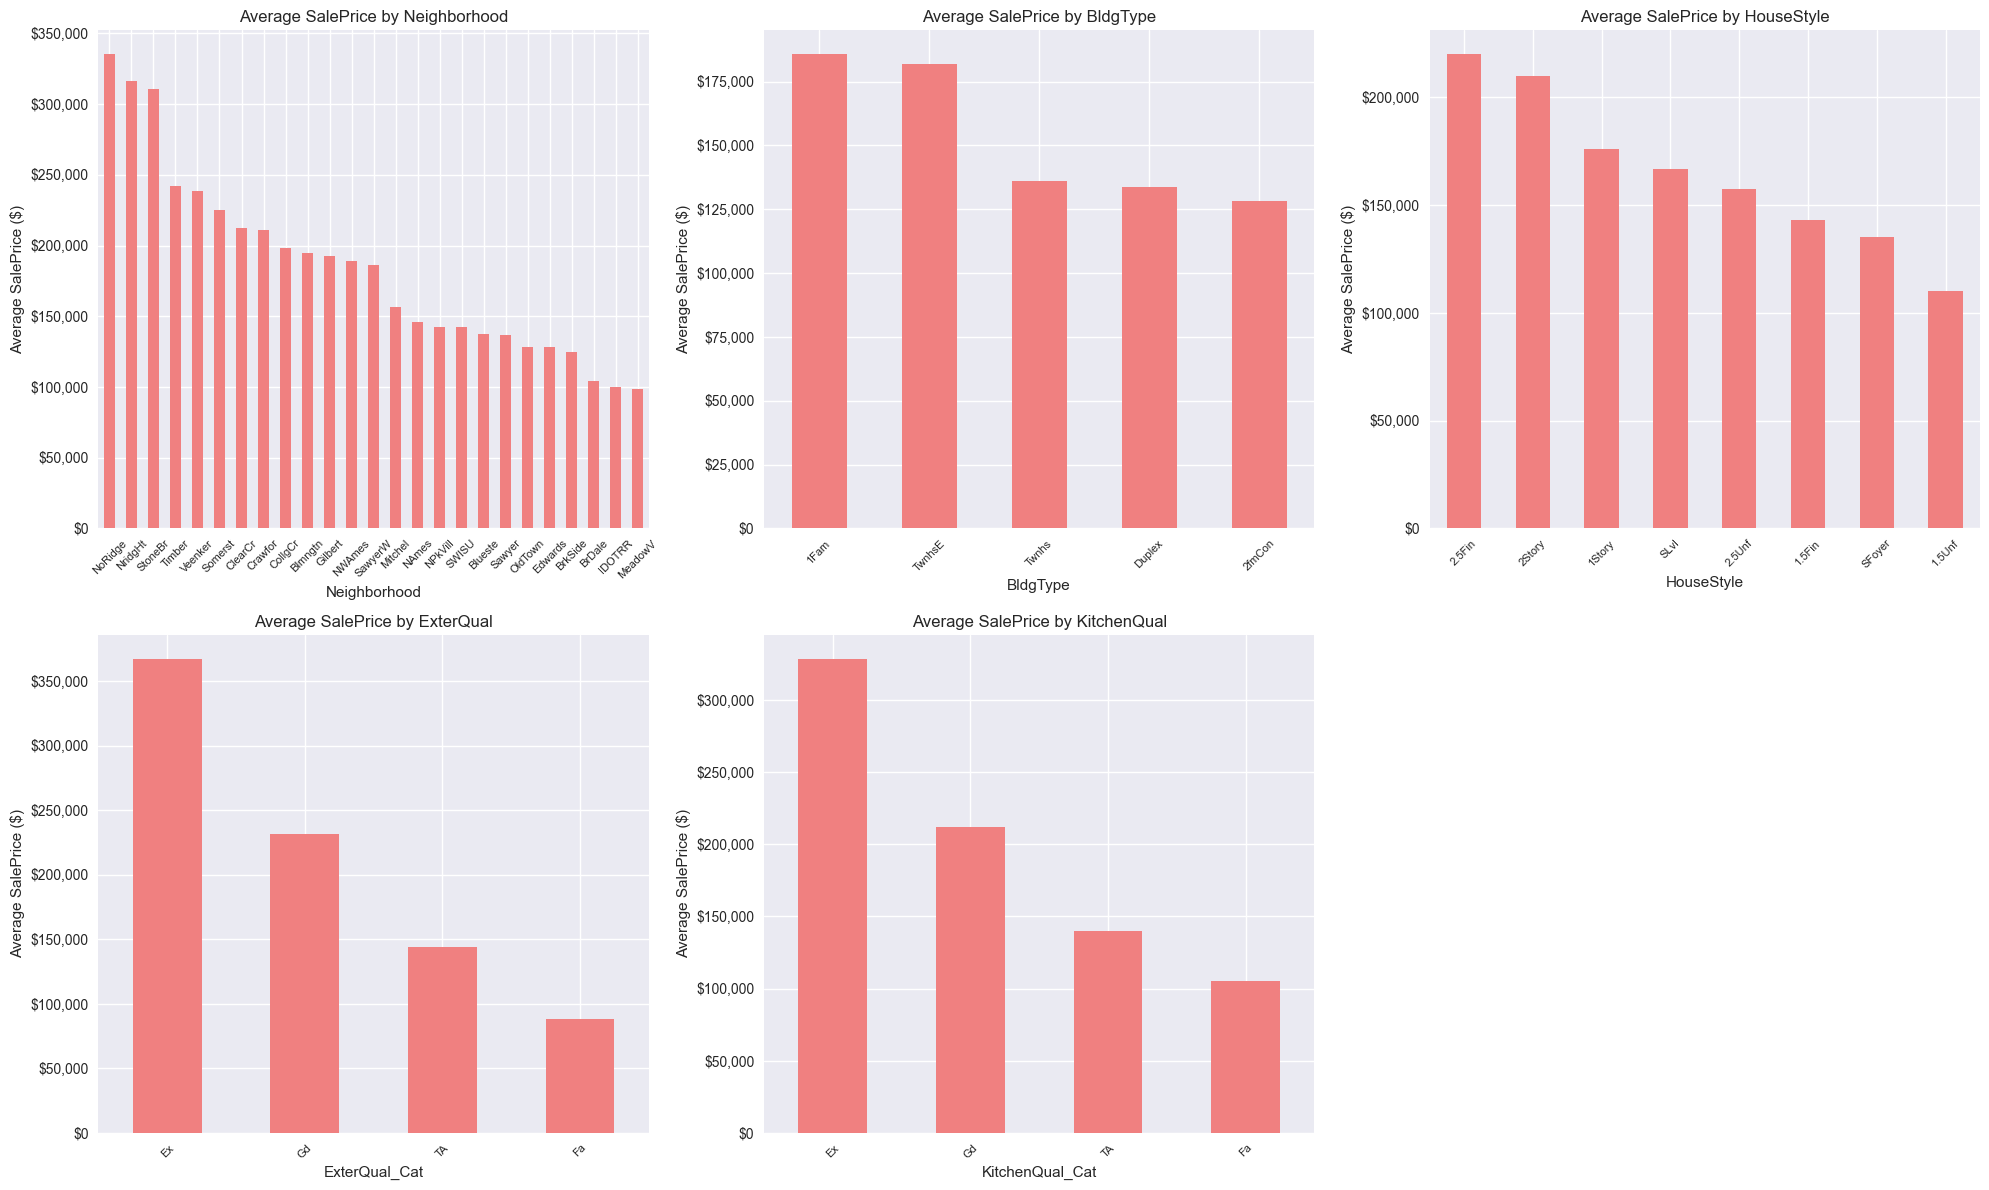

In [ ]:
# Convert numerical quality features back to categories for visualization
quality_mapping = {0: "NA", 1: "Po", 2: "Fa", 3: "TA", 4: "Gd", 5: "Ex"}

# Create temporary categorical versions for plotting
train_data_viz = train_data.copy()
train_data_viz["ExterQual_Cat"] = train_data_viz["ExterQual"].map(quality_mapping)
train_data_viz["KitchenQual_Cat"] = train_data_viz["KitchenQual"].map(quality_mapping)

# Now analyze the original categorical features plus converted quality features
key_categorical = [
    "Neighborhood",
    "BldgType",
    "HouseStyle",
    "ExterQual_Cat",  # Converted back to categorical
    "KitchenQual_Cat",  # Converted back to categorical
]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_categorical):
    if idx < len(axes):
        # Calculate mean price by category
        category_means = (
            train_data_viz.groupby(feature)["SalePrice"]
            .mean()
            .sort_values(ascending=False)
        )

        # Create the plot
        category_means.plot(kind="bar", ax=axes[idx], rot=45, color="lightcoral")
        axes[idx].set_title(f"Average SalePrice by {feature.replace('_Cat', '')}")
        axes[idx].set_ylabel("Average SalePrice ($)")
        axes[idx].tick_params(axis="x", labelsize=8)

        # Format y-axis to show currency
        axes[idx].yaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, p: f"${x:,.0f}")
        )

# Hide empty subplot
if len(key_categorical) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Clean up temporary dataframe
del train_data_viz

<hr>

(8) Data Export for Modeling

In [20]:
# Split back into train and test sets
processed_train = df_all.head(len(train_df))
processed_test = df_all.tail(len(test_df))

print(f"Processed training data shape: {processed_train.shape}")
print(f"Processed test data shape: {processed_test.shape}")

# Save processed data
processed_train.to_csv("processed_train.csv", index=False)
processed_test.to_csv("processed_test.csv", index=False)

# Save data types for reference
dtypes_dict = {}
for column in processed_train.columns:
    dtype_str = str(processed_train[column].dtype)
    # Clean up dtype string for JSON serialization
    dtype_str = dtype_str.replace("(", "*(").replace(")", ")*")
    dtypes_dict[column] = dtype_str

with open("processed_dtypes.json", "w") as f:
    json.dump(dtypes_dict, f, indent=2)

print("Data successfully processed and saved!")
print("Files created:")
print("- processed_train.csv: Training data ready for modeling")
print("- processed_test.csv: Test data ready for predictions")
print("- processed_dtypes.json: Data type reference")

Processed training data shape: (1460, 85)
Processed test data shape: (1459, 85)
Data successfully processed and saved!
Files created:
- processed_train.csv: Training data ready for modeling
- processed_test.csv: Test data ready for predictions
- processed_dtypes.json: Data type reference


## Summary and Next Steps

### Key Findings:

__Data Quality:__ Successfully handled missing values using domain knowledge

__Feature Types:__ Converted categorical identifiers and ordinal features appropriately

__Target Variable:__ SalePrice shows right skewness - consider log transformation for modeling

__Strong Predictors:__ OverallQual, GrLivArea, GarageCars, TotalBsmtSF show high correlation with price

__Categorical Importance:__ Neighborhood and quality ratings significantly impact price

### Recommendations for Modeling:

__Feature Selection:__ Focus on high-correlation numerical features and key categorical variables

__Preprocessing:__ Consider log transformation of SalePrice and skewed numerical features

__Encoding:__ Use appropriate encoding for remaining categorical variables (one-hot, target encoding)

__Validation:__ Implement proper cross-validation strategy

__Models:__ Try ensemble methods (Random Forest, Gradient Boosting) for this type of structured data

### Data Ready for Next Phase:

✅ Missing values handled

✅ Feature types corrected

✅ Ordinal features encoded

✅ Additional features created

✅ Data quality validated

✅ Exploratory analysis completed

The processed data is now ready for feature engineering, model selection, and hyperparameter tuning phases of the machine learning pipeline.